In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [36]:
!nvidia-smi

Wed Oct 14 09:21:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro GV100        Off  | 00000000:37:00.0 Off |                  Off |
| 29%   39C    P2    26W / 250W |   3764MiB / 32508MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

bur_vol_loss        0.422868
loss                0.031918
spin_loss           0.010719
val_bur_vol_loss    0.468485
val_loss            0.045075
val_spin_loss       0.020201
dtype: float64


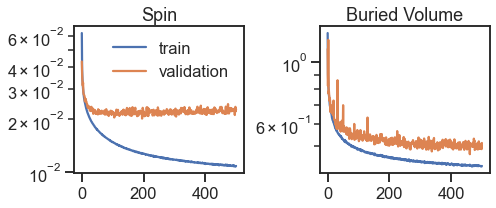

In [37]:
fig, axs = plt.subplots(ncols=2, sharex=True, figsize=(7, 3))

log2 = pd.read_csv('20201012_spin_bv/log.csv', error_bad_lines=False).set_index('epoch')

axs[0].plot(log2['spin_loss'], label='train')
axs[0].plot(log2['val_spin_loss'], label='validation')

axs[0].set_title('Spin')

axs[1].plot(log2['bur_vol_loss'])
axs[1].plot(log2['val_bur_vol_loss'])

axs[1].set_title('Buried Volume')

for ax in axs:
    ax.set_yscale('log')
    
axs[0].legend()

print(log2.min())


plt.tight_layout()
# plt.xlim([0, 10])

In [38]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
import nfp

In [40]:
from preprocess_inputs_spin_bv import preprocessor
preprocessor.from_json('tfrecords_spin_bv/preprocessor.json')

from loss import AtomInfMask, KLWithLogits
from nfp import EdgeUpdate, NodeUpdate, GlobalUpdate
import tensorflow_addons as tfa

model = tf.keras.models.load_model(
    '20201012_spin_bv/best_model.hdf5',
    custom_objects={**nfp.custom_objects,
                    **{'AtomInfMask': AtomInfMask, 'KLWithLogits': KLWithLogits}})

In [88]:
cdf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_spins.csv.gz')
cdf_spin = cdf_spin[cdf_spin.atom_type != 'H']

cdf_bv = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/cdf_buried_volume.csv.gz', index_col=0)
cdf = cdf_spin.merge(cdf_bv, on=['smiles', 'atom_index'], how='left')

cdf['fractional_spin'] = cdf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

test = np.load('split_spin_bv.npz', allow_pickle=True)['test']

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [78]:
cdf_test = cdf[cdf.smiles.isin(test)].copy()

In [70]:
redf_spin = pd.read_csv('/projects/rlmolecule/pstjohn/atom_spins/redf_spins_expanded.csv.gz')
redf_spin = redf_spin[redf_spin.atom_type != 'H']

redf_bv = pd.read_csv('/projects/rlmolecule/svss/Project-Redox/bur-vol_data_water/buried_volumes_water_all.csv.gz')[['atom_index', 'buried_vol', 'smiles']]
redf = redf_spin.merge(redf_bv, on=['smiles', 'atom_index'], how='left')

redf['fractional_spin'] = redf.groupby('smiles').spin.apply(lambda x: x.abs() / x.abs().sum())

redf_smiles = pd.Series(redf.smiles.unique())

redf_test = redf_smiles[redf_smiles.isin(test)]

In [79]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=cdf_test.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [71]:
redf_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(smiles, train=False) for smiles in redf_test),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=128, padded_shapes=preprocessor.padded_shapes(max_atoms=redf.atom_index.max() + 1),
                  padding_values=preprocessor.padding_values)

In [80]:
predicted_spin_logits, predicted_bur_vol = model.predict(test_dataset, verbose=1)
predicted_fractional_spins = tf.nn.softmax(predicted_spin_logits)

/projects/rlmolecule/pstjohn/envs/tf2_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['bond_indices', 'n_bond'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


     17/Unknown - 1s 75ms/step

RDKit WARNING: [09:40:56] Conflicting single bond directions around double bond at index 2.
RDKit WARNING: [09:40:56]   BondStereo set to STEREONONE and single bond directions set to NONE.


40/40 [==============================] - 3s 76ms/step


Text(0.5, 1.0, 'Buried Volume')

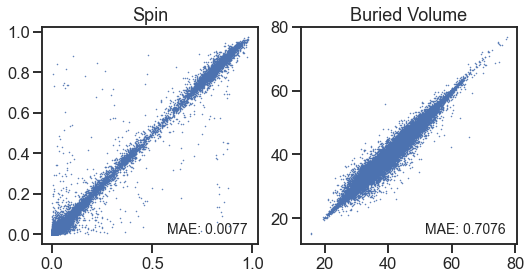

In [81]:
cdf_test_pivot_spins = cdf_test.pivot(index='smiles', columns='atom_index', values='fractional_spin')
cdf_test_pivot_spins = cdf_test_pivot_spins.reindex(test)

cdf_test_pivot_bur_vol = cdf_test.pivot(index='smiles', columns='atom_index', values='buried_vol')
cdf_test_pivot_bur_vol = cdf_test_pivot_bur_vol.reindex(test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(cdf_test_pivot_spins.values.flatten(), predicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_spins.values.flatten() - predicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(cdf_test_pivot_bur_vol.values.flatten(), predicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(cdf_test_pivot_bur_vol.values.flatten() - predicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [72]:
rpredicted_spin_logits, rpredicted_bur_vol = model.predict(redf_dataset, verbose=1)
rpredicted_fractional_spins = tf.nn.softmax(rpredicted_spin_logits)

9/9 [==============================] - 1s 67ms/step


Errors just for molecules that were calculated in water, but were also in the gas phase test dataset

Text(0.5, 1.0, 'Buried Volume')

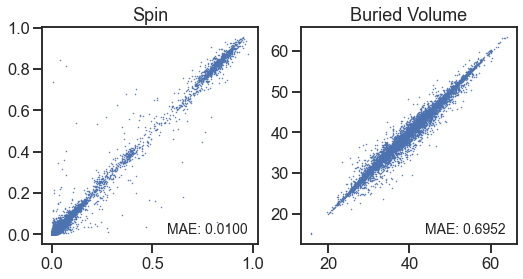

In [73]:
redf_pivot_spins = redf.pivot(index='smiles', columns='atom_index', values='fractional_spin')
redf_pivot_spins = redf_pivot_spins.reindex(redf_test)

redf_pivot_bur_vol = redf.pivot(index='smiles', columns='atom_index', values='buried_vol')
redf_pivot_bur_vol = redf_pivot_bur_vol.reindex(redf_test)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(redf_pivot_spins.values.flatten(), rpredicted_fractional_spins.numpy().flatten(), '.', ms=1)
axs[0].text(.95, .05, f'MAE: {pd.Series(redf_pivot_spins.values.flatten() - rpredicted_fractional_spins.numpy().flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(redf_pivot_bur_vol.values.flatten(), rpredicted_bur_vol.flatten(), '.', ms=1)
axs[1].text(.95, .05, f'MAE: {pd.Series(redf_pivot_bur_vol.values.flatten() - rpredicted_bur_vol.flatten()).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)

axs[0].set_title('Spin')
axs[1].set_title('Buried Volume')

In [89]:
reindex_cdf = cdf.set_index(['smiles', 'atom_index']).reindex(redf[['smiles', 'atom_index']])

In [92]:
redf

,smiles,atom_type,atom_index,spin,buried_vol,fractional_spin
0,[CH2]C1=COCC1,C,0,0.586646,30.291542,0.405000
1,[CH2]C1=COCC1,C,1,-0.180922,41.879991,0.124902
2,[CH2]C1=COCC1,C,2,0.570409,38.252099,0.393790
3,[CH2]C1=COCC1,O,3,0.096694,33.700549,0.066754
4,[CH2]C1=COCC1,C,4,-0.002564,34.074425,0.001770
...,...,...,...,...,...,...
740620,[CH2]N1CCC(=O)N1C,C,3,0.022799,39.900312,0.021027
740621,[CH2]N1CCC(=O)N1C,C,4,-0.000727,45.453995,0.000670
740622,[CH2]N1CCC(=O)N1C,O,5,0.006317,31.509441,0.005826
740623,[CH2]N1CCC(=O)N1C,N,6,0.005283,51.115920,0.004872


Text(0.95, 0.05, 'MAE: 0.1624')

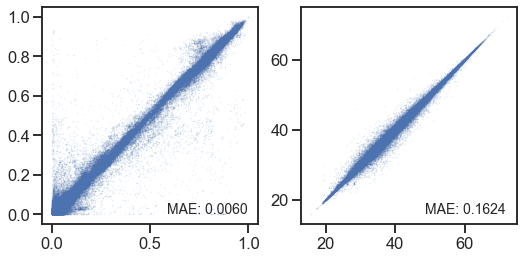

In [97]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8.5,4))
axs[0].plot(reindex_cdf.fractional_spin, redf.fractional_spin, '.', ms=1, alpha=.1)
axs[0].text(.95, .05, f'MAE: {pd.Series(reindex_cdf.fractional_spin.values - redf.fractional_spin.values).dropna().abs().mean():.4f}', ha='right',
            transform=axs[0].transAxes, fontsize=14)

axs[1].plot(reindex_cdf.buried_vol, redf.buried_vol, '.', ms=1,  alpha=.1)
axs[1].text(.95, .05, f'MAE: {pd.Series(reindex_cdf.buried_vol.values - redf.buried_vol.values).dropna().abs().mean():.4f}', ha='right',
            transform=axs[1].transAxes, fontsize=14)